# Constants

In [ ]:
# Continuous state-space bounds (x1, x2) and discretization parameters
x1_min = 0
x2_min = 0
x1_max = 10
x2_max = 10

# Control bounds (not directly used below; controls are enumerated via vx/vy grids)
vx_min = -1
vx_max = 1
vy_min = -1
vy_max = 1

# Additive disturbance bounds (w) and time step
w1_max = 0.05
w2_max = 0.05
w1_min = -0.05
w2_min = -0.05
tau = 1

# Grid sizes for the abstraction: Nx1 x Nx2 discrete positions, and Nvx x Nvy discrete controls
Nx1 = 100
Nx2 = 100
Nvx = 3
Nvy = 3

# Discrete state space in grid coordinates (1-indexed cells)
all_states = {(i, j) for i in range(1, Nx1 + 1) for j in range(1, Nx2 + 1)}

# Named rectangular regions in the continuous plane (used as labels and/or constraints)
R1 = [[4,5],
        [8.5,9.5]]
R2 = [[8.5,9.5],
        [2,3]]
R3 = [[2.0,3.0],
        [0.5,1.5]]
R4 = [[3.0,7.0],
        [3.0,7.0]]

# Default catalog of regions (reused by plotting and by the original automaton)
DEFAULT_ZONES = {
    "R1": R1,
    "R2": R2,
    "R3": R3,
    "R4": R4,
}

# Discrete control set U (cartesian product vx x vy); sigma will index into this list
vx = [-0.4, 0, 0.4]
vy = [-0.4, 0, 0.4]
u = [(vx[i], vy[j]) for i in range(Nvx) for j in range(Nvy)]

# Basic functions

In [ ]:
# One-step dynamics (Euler-style): x_{t+1} = x_t + tau * (v + w)
def function(xt, vt, wt):
  return [xt[0] + tau * vt[0] + tau * wt[0],
          xt[1] + tau * vt[1] + tau * wt[1]]

In [ ]:
# Discretization utilities: map continuous points <-> grid cells
# Concrétisation de l'ensemble
def q(x):
    # Map a continuous point x=(x1,x2) into a 1-indexed grid cell (i,j)
    if x[0] == x1_max: i = Nx1
    else: i = int(x[0] * (Nx1 / x1_max)) + 1
    if (x[1] == x2_max): j = Nx2   # edge case
    else: j = int(x[1] * (Nx2 / x2_max)) + 1

    return (i, j)

def qm1(xi):
  # Inverse map: return the continuous rectangle (cell bounds) corresponding to grid cell xi
  x_min = ((xi[0] - 1) * (x1_max / Nx1), (xi[1] - 1) * (x2_max / Nx2))
  x_max = ((xi[0] - 1) * (x1_max / Nx1) + (x1_max / Nx1), (xi[1] - 1) * (x2_max / Nx2) + (x2_max / Nx2))
  return [x_min, x_max]

def Q(interval):
  # Convert a continuous axis-aligned rectangle into the set of grid cells it covers
  min_range = q((interval[0][0], interval[1][0]))
  max_range = q((interval[0][1], interval[1][1]))
  return {(i, j) for i in range(min_range[0], max_range[0]) for j in range(min_range[1], max_range[1])}

In [ ]:
# Decode a control index sigma (1..|U|) into an actual (vx, vy) pair
def p(sigma):
  return u[sigma - 1]

In [ ]:
# Over-approximate the (continuous) post set of a grid cell xi under control sigma
# by propagating the cell corners with worst-case disturbances.
def Y(xi, sigma):
  w_max = [w1_max, w2_max]
  w_min = [w1_min, w2_min]
  I = qm1(xi)
  xi_min = I[0]
  xi_max = I[1]
  u_sigma = p(sigma)
  f_min = function(xi_min, u_sigma, w_min)
  f_max = function(xi_max, u_sigma, w_max)
  return [f_min, f_max]



In [ ]:
# Discrete transition relation: successors of grid cell xi under control sigma
def g(xi, sigma):
  Y2 = Y(xi, sigma)
  borne_min = q(Y2[0])
  borne_max = q(Y2[1])

  i_min = borne_min[0]
  j_min = borne_min[1]
  i_max = borne_max[0]
  j_max = borne_max[1]

  return {(i, j) for i in range(i_min, i_max + 1) for j in range(j_min, j_max + 1)}

In [ ]:
# Backward (approximate) dynamics used for predecessor computations:
# apply the opposite control to over-approximate the inverse image.
def Ym1(xi, sigma):
  w_max = [w1_max, w2_max]
  w_min = [w1_min, w2_min]
  I = qm1(xi)
  xi_min = I[0]
  xi_max = I[1]
  u_sigma = (-p(sigma)[0], -p(sigma)[1])
  f_min = function(xi_min, u_sigma, w_min)
  f_max = function(xi_max, u_sigma, w_max)
  return [f_min, f_max]

# Discrete predecessor relation: all grid cells that can reach xi under sigma
def gm1(xi, sigma):
  Y2 = Ym1(xi, sigma)
  borne_min = q(Y2[0])
  borne_max = q(Y2[1])

  i_min = borne_min[0]
  j_min = borne_min[1]
  i_max = borne_max[0]
  j_max = borne_max[1]

  return {(i, j) for i in range(i_min, i_max + 1) for j in range(j_min, j_max + 1)}

In [ ]:
def interval_intersects_region(I, R):
    """Return True when axis-aligned rectangles I and R overlap."""
    x0_min, x0_max = sorted(I[0])
    y0_min, y0_max = sorted(I[1])
    rx_min, rx_max = sorted(R[0])
    ry_min, ry_max = sorted(R[1])
    return not (
        x0_max <= rx_min + 1e-6
        or x0_min >= rx_max - 1e-6
        or y0_max <= ry_min + 1e-6
        or y0_min >= ry_max - 1e-6
    )

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Quick visualization helper: draw regions and (discrete/product) paths on the same figure
def plot_regions_and_product_paths(paths=None, regions=None, zones_local=None, title='2D Regions & Paths'):
    fig, ax = plt.subplots(figsize=(8, 8))

    if regions is None:
        regions = zones

    # --- Plot regions ---
    color_map = {'R1': '#b3e6ff', 'R2': '#b3ffcc', 'R3': '#ffdf80', 'R4': '#ffb3b3'}
    for name, R in regions.items():
        x_min, x_max = R[0]
        y_min, y_max = R[1]
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1.5, edgecolor='black',
                                 facecolor=color_map.get(name, '#dddddd'), alpha=0.6)
        ax.add_patch(rect)
        ax.text((x_min+x_max)/2, (y_min+y_max)/2, name, ha='center', va='center',
                fontsize=10, weight='bold')



    # Convert to centers
    def to_centers(path_seq):
        pts = []
        for el in path_seq:
            if isinstance(el, tuple) and len(el) == 2 and isinstance(el[0], tuple):
                pos = el[0]
            else:
                pos = el
            try:
                I = qm1(pos)
                cx = (I[0][0] + I[1][0]) / 2.0
                cy = (I[0][1] + I[1][1]) / 2.0
                pts.append((cx, cy))
            except:
                continue
        return pts

    # --- Plot list of paths with jitter to avoid overlap ---
    if paths is not None:
        epsilon = 0.02  # small shift, tuned so it's invisible but separates overlapping paths

        for i, p in enumerate(paths):
            pts = to_centers(p)
            if pts:
                # Apply jitter
                jittered = [(x + epsilon*i, y - epsilon*i) for (x, y) in pts]

                xs, ys = zip(*jittered)
                ax.plot(xs, ys, '-o', linewidth=1.5, markersize=4,
                        label=f'path {i+1}')

    # --- Final plot ---
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()




# Basic system

In [ ]:
# Predecessor operator for the robust abstraction:
# states that have *some* control such that all successors stay inside R_total.
def Pre(R, R_total):
    result = set()
    for xi in R:
        X = set()
        # holds ONLY if w_min = -w_max
        for k in range(1, Nvx * Nvy + 1):
          inversed_states = gm1(xi, k)
          for state in inversed_states:
            if g(state, k).issubset(R_total):
              X.add(state)
        result.update(X)
    return result

In [ ]:
# Compute the maximal controlled invariant subset of Qs (classic safety fixed point)
def safety(Qs):
  R0 = Qs
  while True:
    R1 = Qs.intersection(Pre(R0, R0))
    print("Safety", len(R1))
    if R1 == R0:
      break
    R0 = R1
  return R1

# Backward reachability in the (robust) transition system, using gm1 and a subset check
def reachability(Qr):
    # R is the set of all discovered states
    R = set(Qr)

    # queue of states to process
    Q = deque(Qr)

    while Q:
        el = Q.popleft()

        # enumerate the predecessors of el in the *product system*
        for k in range(1, Nvx * Nvy + 1):
            preds = gm1(el, k)
            for p in preds:
                next_states = g(p, k)
                # acceptance condition: g(p, k) ⊆ R (the current known set)
                if p not in R and next_states.issubset(all_states) and next_states.issubset(R):
                    R.add(p)
                    Q.append(p)

    return R


In [ ]:
# All admissible controls from x0 that keep the next (over-approximated) set inside R
def controller(x0, R):
  result = set()
  for k in range(1, Nvx * Nvy + 1):
    if g(x0, k).issubset(R):
      result.add(k)
  return result

In [ ]:
from collections import deque
# Construct an example controlled path (purely on the grid) by BFS
def find_controlled_path_bfs(start, target, safe_set):
    # safe = safety(all_states.difference(rejected_states)).intersection(reachability(accepted_states))
    if start not in safe_set:
      return None
    queue = deque([(start, [start])])
    visited = set([start])

    while queue:
        state, path = queue.popleft()

        if state in target:
            return path

        commands = controller(state, safe_set)
        for command in commands:
            next_states = g(state, command)
            for next_state in next_states:
                if next_state not in visited:
                  visited.add(next_state)
                  queue.append((next_state, path + [next_state]))

    return None



# Product system

In [ ]:
# Product-system transition: combine grid motion with automaton progression via labels
def h(pxi, sigma, automaton_transition, zones):
  xi, state = pxi
  next_positions = g(xi, sigma)
  result = set()
  for position in next_positions:
    label = labels(position, zones)

    result.add((position, automaton_transition(state, label)))
  return result

In [ ]:
# Product-system predecessors: positions that could lead to (xi, actual_state)
def hm1(pxi, sigma, automaton_transition, automaton_states, zones):
  xi, actual_state = pxi
  previous_states = gm1(xi, sigma)
  result = set()
  for position in previous_states:
    label = labels(position, zones)
    for state in automaton_states:
      if automaton_transition(state, label) == actual_state:
        result.add((position, state))
  return result

In [ ]:
from collections import deque

# Backward reachability on the product system (grid x automaton)
def reachabilityPS(Qr, automaton_transition, automaton_states, zones, all_product_states):
    # R is the set of all discovered states
    R = set(Qr)

    # queue of states to process
    Q = deque(Qr)

    while Q:
        el = Q.popleft()

        # enumerate the predecessors of el in the *product system*
        # This is basically what hm1(el, k, ...) returns.
        for k in range(1, Nvx * Nvy + 1):
            preds = hm1(el, k, automaton_transition, automaton_states, zones)
            for p in preds:
                next_states = h(p, k, automaton_transition, zones)
                # acceptance condition: h(p, k) ⊆ R (the current known set)
                if p not in R and p in all_product_states and next_states.issubset(all_product_states) and next_states.issubset(R):
                    R.add(p)
                    Q.append(p)

    return R

In [ ]:
# Helper: build accepting product states from accepting automaton states
def get_accepted_states(automaton_accepting):
  return {(position, state) for position in all_states for state in automaton_accepting}



In [ ]:
# Controls that keep the next product-state set within R
def controllerPS(x0, R, automaton_transition, zones):
  result = set()
  for k in range(1, Nvx * Nvy + 1):
    if h(x0, k, automaton_transition, zones).issubset(R):
      result.add(k)
  return result

In [ ]:
from collections import deque
# BFS that returns a concrete grid path (positions only) that reaches an accepting product state
def find_controlled_path_bfsPS(start, target, safe_set, automaton_transition, zones):
    # safe = safety(all_states.difference(rejected_states)).intersection(reachability(accepted_states))
    if start not in safe_set:
      return None
    queue = deque([(start, [start[0]])])
    visited = set([start])

    while queue:
        state, path = queue.popleft()

        if state in target:
            return path

        commands = controllerPS(state, safe_set, automaton_transition, zones)
        for command in commands:
            next_states = h(state, command, automaton_transition, zones)
            for next_state in next_states:
                if next_state not in visited:
                  visited.add(next_state)
                  queue.append((next_state, path + [next_state[0]]))

    return None

# Automaton Design


In [ ]:
AUTOMATON_ALPHABET_BASE = [None, "R1", "R2", "R3", "R4"]

# Utility: expand a transition function into an explicit table for printing/export
def build_automaton_table_from_function(states, transition_func, alphabet=None):
    if alphabet is None:
        alphabet = list(AUTOMATON_ALPHABET_BASE)
    tbl = {}
    for qstate in states:
        tbl[qstate] = {}
        for lab in alphabet:
            tbl[qstate][lab] = transition_func(qstate, lab)
    return tbl

In [ ]:
# Core labels the automata understand
CORE_LABELS = {None, "R1", "R2", "R3", "R4"}


In [ ]:
# automaton
automaton_states_original = ['q0', 'q1_R1', 'q1_R2', 'q2', 'q_trap']  # [a,b,c,d,e] from the paper
automaton_initial_original = 'q0'
automaton_accepting_original = {'q2'}

# Hard-coded DFA for the original spec (visit R1 or R2, then reach R3, avoid R4)
def automaton_transition_original(q, label):
    if q == 'q_trap':
        return 'q_trap'

    if label == 'R4':
        return 'q_trap'

    if q == 'q0':
        if label == 'R1':
            return 'q1_R1'
        if label == 'R2':
            return 'q1_R2'
        return 'q0'

    if q == 'q1_R1':
        if label == 'R2':
            return 'q_trap'
        if label == 'R3':
            return 'q2'
        return 'q1_R1'

    if q == 'q1_R2':
        if label == 'R1':
            return 'q_trap'
        if label == 'R3':
            return 'q2'
        return 'q1_R2'

    if q == 'q2':
        if label == 'FORBIDDEN':
            return 'q_trap'
        return 'q2'

    return 'q_trap'



In [ ]:
# user defined automaton

# Build a DFA from (from,label,to) triples. Supports wildcard '*' and 'none' as None.
def _build_automaton_core(states, initial, accepting, transitions_raw, internal_alphabet):
    # -------------------------
    # Validate states
    # -------------------------
    for st, lbl, nxt in transitions_raw:
        if st not in states:
            raise ValueError(f"Transition uses unknown state '{st}'")
        if nxt not in states:
            raise ValueError(f"Transition uses unknown target '{nxt}'")

    # -------------------------
    # Label parser
    # -------------------------
    def parse_label(lbl):
        low = str(lbl).strip().lower()
        if low == "*":
            return "*"
        if low == "none":
            return None
        return lbl.strip()

    # -------------------------
    # Initialize full automaton
    # -------------------------
    transition_table = {
        s: {lab: "q_trap" for lab in internal_alphabet}
        for s in states
    }

    # -------------------------
    # First: apply wildcard transitions
    # -------------------------
    for st, lbl, nxt in transitions_raw:
        lab = parse_label(lbl)
        if lab == "*":
            for lab2 in internal_alphabet:
                transition_table[st][lab2] = nxt

    # -------------------------
    # Second: specific transitions override wildcard
    # -------------------------
    for st, lbl, nxt in transitions_raw:
        lab = parse_label(lbl)
        if lab != "*":
            if lab not in internal_alphabet:
                raise ValueError(
                    f"Label '{lbl}' in ({st}, {lbl} -> {nxt}) is invalid. "
                    f"Allowed labels: {internal_alphabet + ['*']}"
                )
            transition_table[st][lab] = nxt

    # -------------------------
    # Define transition function
    # -------------------------
    def automaton_transition_custom(q, label):
        return transition_table[q][label]

    return (
        states,
        initial,
        set(accepting),
        automaton_transition_custom,
        transition_table
    )




def build_automaton_custom_from_json(json_obj, internal_alphabet):
    if "states" not in json_obj or "initial" not in json_obj:
        raise ValueError("JSON must include 'states' and 'initial'.")

    states = list(json_obj["states"])
    initial = json_obj["initial"]
    accepting = set(json_obj.get("accepting", []))

    transitions_raw = []
    for t in json_obj.get("transitions", []):
        st = t["from"]
        lbl = t["label"]
        nxt = t["to"]
        transitions_raw.append((st, lbl, nxt))

    return _build_automaton_core(states, initial, accepting, transitions_raw, internal_alphabet)


In [ ]:
# Label a grid cell by checking where its center lies (None if in no region)
def labels(state, zones):
    I = qm1(state)
    cx = (I[0][0] + I[1][0]) / 2.0
    cy = (I[0][1] + I[1][1]) / 2.0

    for name, bounds in zones.items():
        if bounds[0][0] <= cx <= bounds[0][1] and bounds[1][0] <= cy <= bounds[1][1]:
            return name
    return None



In [ ]:
# Project the winning set of product states back to winning initial positions
def find_winning_initial_states(controller_set, automaton_initial):
    return {pos for (pos, q) in controller_set if q == automaton_initial}

In [ ]:
# Pretty-print the automaton transition table in a compact ASCII layout
def print_automaton_transition_table(states, transition_table, alphabet):
    header = ['STATE'] + [('none' if a is None else a) for a in alphabet]
    rows = [header]
    for s in states:
        row = [s] + [transition_table[s][lab] for lab in alphabet]
        rows.append(row)
    widths = [max(len(str(r[i])) for r in rows) for i in range(len(header))]
    for r in rows:
        print(" | ".join(str(c).ljust(widths[i]) for i, c in enumerate(r)))

In [ ]:
# Export the DFA to Graphviz DOT for visualization
def export_automaton_to_dot(filename, states, initial, accepting, transition, alphabet):
    edges = {}
    for s in states:
        for lab in alphabet:
            nxt = transition(s, lab)
            edges.setdefault((s, nxt), []).append(lab)
    with open(filename, 'w') as f:
        f.write('digraph DFA {\n')
        f.write('  rankdir=LR;\n')
        f.write('  node [shape=circle];\n')
        for s in states:
            if s in accepting:
                f.write(f'  "{s}" [shape=doublecircle];\n')
            else:
                f.write(f'  "{s}";\n')
        f.write(f'  __start__ [shape=point];\n')
        f.write(f'  __start__ -> "{initial}";\n')
        for (s, nxt), labs in edges.items():
            labstr = ",".join(["None" if l is None else str(l) for l in labs])
            f.write(f'  "{s}" -> "{nxt}" [label="{labstr}"];\n')
        f.write('}\n')
    print('DOT saved to', filename)
    print('Convert locally: dot -Tpng', filename, '-o', filename.replace(".dot", ".png"))

# Run

In [ ]:
import os
import pickle
from datetime import datetime

def save_winning_set(winning_set, spec_name, zones_config, automaton_name=None):
    """Save winning set with metadata for future suggestions"""

    # Create unique identifier for this configuration
    config_id = f"{spec_name}_{automaton_name or 'default'}"
    if zones_config:
        dz_names = "_".join(sorted(zones_config.keys()))
        config_id += f"_dz_{dz_names}"

    # Create filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"winning_set_{config_id}_{timestamp}.pkl"

    # Prepare data to save
    data = {
        'winning_set': winning_set,
        'spec_name': spec_name,
        'automaton_name': automaton_name,
        'zones': zones_config.copy(),
        'timestamp': timestamp,
        'config_id': config_id
    }

    with open(filename, 'wb') as f:
        pickle.dump(data, f)

    print(f"✓ Winning set saved as: {filename}")
    return filename, config_id

In [ ]:
def load_suggested_winning_sets():
    """Load and return available winning sets with their configurations"""
    suggestions = {}

    for filename in os.listdir('.'):
        if filename.startswith('winning_set_') and filename.endswith('.pkl'):
            try:
                with open(filename, 'rb') as f:
                    data = pickle.load(f)

                zone_data = data.get('zones') or data.get('danger_zones', {})

                # Create a friendly description
                desc = f"Spec: {data['spec_name']}"
                if data['automaton_name']:
                    desc += f", Automaton: {data['automaton_name']}"
                if zone_data:
                    dz_list = ", ".join(zone_data.keys())
                    desc += f", Zones: {dz_list}"
                desc += f" ({data['timestamp']})"

                suggestions[data['config_id']] = {
                    'filename': filename,
                    'description': desc,
                    'data': data,
                    'zones': zone_data
                }

            except Exception as e:
                print(f"Warning: Could not load {filename}: {e}")

    return suggestions

In [ ]:
def suggest_winning_sets(current_spec, current_zones, automaton_name=None):
    """Suggest previously saved winning sets that match current configuration"""
    suggestions = load_suggested_winning_sets()

    if not suggestions:
        return None

    # Create current config ID for matching
    current_config_id = f"{current_spec}_{automaton_name or 'default'}"
    if current_zones:
        dz_names = "_".join(sorted(current_zones.keys()))
        current_config_id += f"_dz_{dz_names}"

    # Look for exact matches first
    if current_config_id in suggestions:
        return suggestions[current_config_id]

    # Look for partial matches (same spec and automaton)
    partial_matches = {}
    base_id = f"{current_spec}_{automaton_name or 'default'}"
    for config_id, suggestion in suggestions.items():
        if config_id.startswith(base_id):
            partial_matches[config_id] = suggestion

    if partial_matches:
        return list(partial_matches.values())[0]  # Return first partial match

    return None

In [ ]:
import json, os

DATA_FILE = "data.json"

# Lightweight persistence for zones/automata/winning sets/paths (kept in the workspace)
def load_data():
    if not os.path.exists(DATA_FILE):
        return {"zones":{}, "automata":{}, "winning_sets":{}, "paths":{}, "classical": {"paths":{}}}
    with open(DATA_FILE,"r") as f:
        return json.load(f)

def save_data(data):
    with open(DATA_FILE,"w") as f:
        json.dump(data,f,indent=2)

In [ ]:
DATA = load_data()

==== Classical 2D Runner ====
Using grid Q_set size: 10000

>>> Cached winning set found! Loading instead of recomputing.
Winning initial positions: 8400
How many paths you want to print from that winning position (from 1 to 8400): 1
A saved path already exists for this (spec, danger zones, start).
Using saved path.


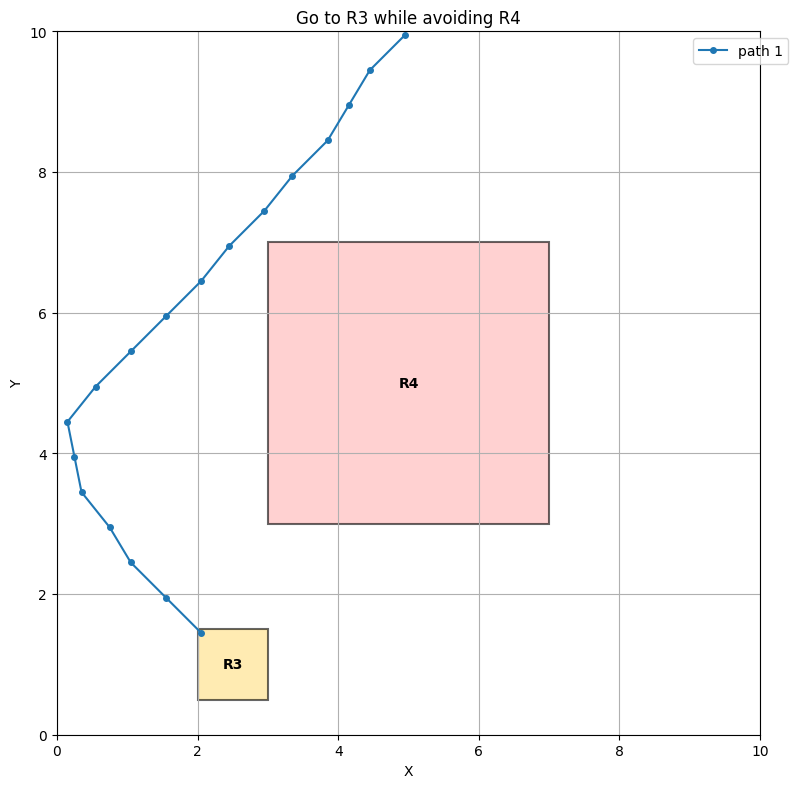

In [ ]:
classical = DATA["classical"] # key -> list of [[i,j]
saved_paths = DATA["classical"]["paths"]
regions_dict = {"R1":R1, "R2":R2, "R3":R3, "R4":R4}
print("==== Classical 2D Runner ====")

print("Using grid Q_set size:", len(all_states))
# Classic reach-avoid: avoid R4 (rejected), and try to reach R3 (accepted)
rejected_states = Q(R4)
safe_states = all_states - rejected_states
accepted_states = Q(R3)

if "winning" in classical:
    print("\n>>> Cached winning set found! Loading instead of recomputing.")
    loaded = classical["winning"]
    winning = {(pos[0], pos[1]) for pos in loaded}
else:
    print("Computing reachability...")
    winning = safety(safe_states).intersection(reachability(accepted_states))
    # Save in a JSON-friendly format
    serial = list(winning)
    classical["winning"] = serial
    DATA["classical"] = classical
    save_data(DATA)
    print("Winning set saved for future runs.")

# -------------------------------------------------------
print("Winning initial positions:", len(winning))
if winning:
    number = int(input("How many paths you want to print from that winning position (from 1 to " + str(len(winning)) + "): " ))
    paths = []
    for position in winning:
        key = f"{position}"
        if key in saved_paths:
            print("A saved path already exists for this (spec, danger zones, start).")
            print("Using saved path.")
            path = [(element[0], element[1]) for element in saved_paths[key]]  # reuse saved path
        else:
            path = find_controlled_path_bfs(
                  position,
                  accepted_states,
                  winning,
                  )
            print("Saving new path for this configuration.")
            DATA["classical"]["paths"][key] = path
            save_data(DATA)
        paths.append(path)
        if len(paths) == number: break
    zones = {"R3": R3, "R4": R4}
    paths = [find_controlled_path_bfs(
                  (50, 100),
                  accepted_states,
                  winning,
                  )]
    plot_regions_and_product_paths(
         paths,
         zones,
         DEFAULT_ZONES,
         "Go to R3 while avoiding R4"
    )
else:
    print("No winning initial positions for this configuration.")




==== 2D Polished Runner ====
Available specs: original, custom, homeschoolmarkethome, homesweethome, libghiti, lllll, no, lala
SPECIFICATION (default original): custom

=== Zones ===
Existing saved zones: R1, R2, R3, R4, construction, construction_A, home, market, park, road_main, school, store

You can now add MULTIPLE regions.
Options:
  - Type:   custom name,xlo,xhi,ylo,yhi
  - Press ENTER to stop adding regions.

Add region (or ENTER to stop): home,0.7,1.7,0.7,1.7
✓ Added custom region 'home': [[0.7, 1.7], [0.7, 1.7]]

Add region (or ENTER to stop): school,7.9,9.3,7.6,9.0
✓ Added custom region 'school': [[7.9, 9.3], [7.6, 9.0]]

Add region (or ENTER to stop): store,7.8,9.1,1.0,2.2
✓ Added custom region 'store': [[7.8, 9.1], [1.0, 2.2]]

Add region (or ENTER to stop): construction,3.2,6.3,3.1,6.2
✓ Added custom region 'construction': [[3.2, 6.3], [3.1, 6.2]]

Add region (or ENTER to stop): 
Enter automaton JSON: {   "states": ["q0", "qS", "qT", "qST", "qTS", "q_acc", "q_trap"],   "i

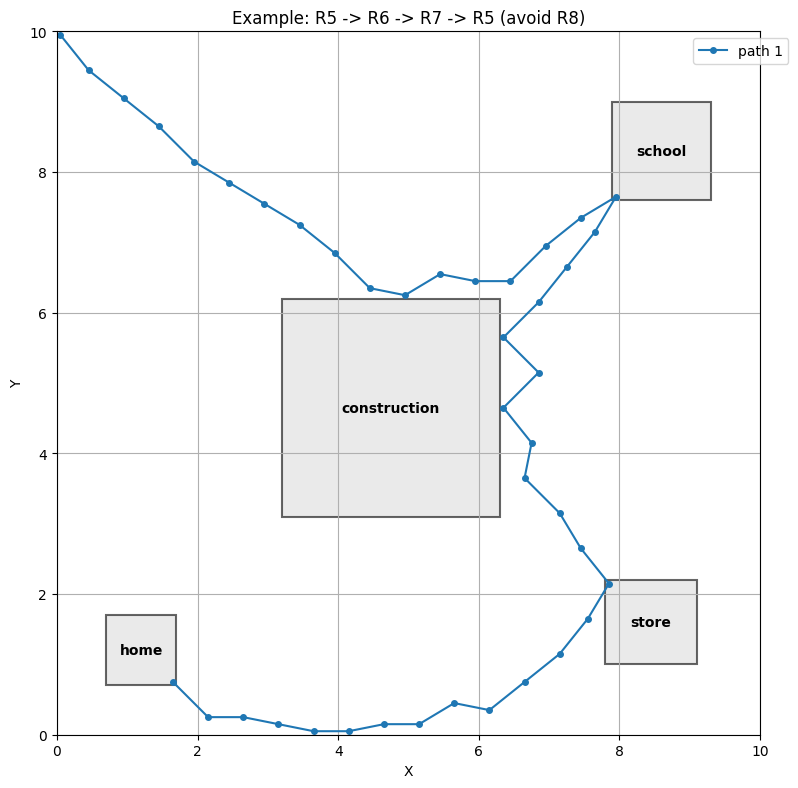

DOT saved to automaton_export.dot
Convert locally: dot -Tpng automaton_export.dot -o automaton_export.png


In [ ]:

# Interactive runner that lets you pick an automaton/spec and zones, caches results in data.json
# Convenience local views
zones_saved = DATA["zones"]      # name -> [[xlo,xhi],[ylo,yhi]]
automata = DATA["automata"]              # name -> text block
winning_sets = DATA["winning_sets"]      # key -> list of [[i,j], q]
zones = {}

# Ensure default zones are always available for reuse
updated_defaults = False
for name, bounds in DEFAULT_ZONES.items():
    if name not in zones_saved:
        zones_saved[name] = [
            [bounds[0][0], bounds[0][1]],
            [bounds[1][0], bounds[1][1]]
        ]
        updated_defaults = True
if updated_defaults:
    DATA["zones"] = zones_saved
    save_data(DATA)

print("==== 2D Polished Runner ====")
# -------------------------------------------------------
available_specs = ["original", "custom"] + list(automata.keys())
print("Available specs:", ", ".join(available_specs))
spec = input("SPECIFICATION (default original): ").strip() or "original"
# -------------------------------------------------------
if spec in automata:
    # Load from saved specs
    json_input = automata[spec]["json"]
    alphabet = automata[spec]["alphabet"]
    automaton_states, automaton_initial, automaton_accepting, automaton_transition, automaton_transition_table = \
        build_automaton_custom_from_json(json_input, alphabet)

    # Rebuild the zones that were active when the automaton was saved
    zone_names = [lab for lab in alphabet if lab is not None]
    for name in zone_names:
        if name in zones_saved:
            zones[name] = zones_saved[name]
        elif name in DEFAULT_ZONES:
            zones[name] = DEFAULT_ZONES[name]
    if not zones:
        zones = {name: DEFAULT_ZONES[name] for name in DEFAULT_ZONES}
elif spec == "original":
    # Use built-in original version
    automaton_states = automaton_states_original
    automaton_initial = automaton_initial_original
    automaton_accepting = automaton_accepting_original
    automaton_transition = automaton_transition_original
    zones = {name: DEFAULT_ZONES[name] for name in DEFAULT_ZONES}
    alphabet = list(AUTOMATON_ALPHABET_BASE)
    automaton_transition_table = build_automaton_table_from_function(
        automaton_states, automaton_transition,
        alphabet=alphabet
    )
else:
    # Custom automaton, not saved yet
    zones = {}
    print("\n=== Zones ===")
    print("Existing saved zones:", ", ".join(sorted(zones_saved.keys())) or "(none)")
    print(
        "\nYou can now add MULTIPLE regions.\n"
        "Options:\n"
        "  - Type:   custom name,xlo,xhi,ylo,yhi\n"
        "  - Press ENTER to stop adding regions.\n"
    )
    new_added = []   # list of names added in this run
    while True:
        entry = input("Add region (or ENTER to stop): ").strip()
        if not entry:
            break
        # Case 1 — user chooses an existing suggested region R4, ...
        if entry in zones_saved:
            name = entry
            cand = zones_saved[entry]
            print(f"Selected suggested region {entry}: {cand}")
            # Check intersection with already-added zones
            conflict = False
            for zname, zreg in zones.items():
                if interval_intersects_region(cand, zreg):
                    print(f"ERROR: suggested region {entry} intersects previously added zone '{zname}'. Ignoring.")
                    conflict = True
                    break
            if conflict:
                continue
            # OK — add it (copy region)
            zones[name] = [
                [cand[0][0], cand[0][1]],
                [cand[1][0], cand[1][1]]
            ]
            print(f"✓ Added region '{name}'\n")
            continue
        # Case 2 — custom "name,xlo,xhi,ylo,yhi"
        try:
            name, xlo, xhi, ylo, yhi = [s.strip() for s in entry.split(",")]
            cand = [[float(xlo), float(xhi)], [float(ylo), float(yhi)]]
            # Check intersection with already-added zones
            for zname, zreg in zones.items():
                if interval_intersects_region(cand, zreg):
                    print(f"ERROR: custom region intersects existing zone '{zname}'. Try again.")
                    raise ValueError("intersection")
            # OK — save
            zones[name] = cand
            zones_saved[name] = [
                [cand[0][0], cand[0][1]],
                [cand[1][0], cand[1][1]]
            ]
            DATA["zones"] = zones_saved
            save_data(DATA)
            new_added.append(name)
            print(f"✓ Added custom region '{name}': {cand}\n")
        except ValueError:
            # Already handled intersection message
            continue
        except Exception as e:
            print("ERROR parsing custom region:", e)
            continue
    # input format
    """
    {
      "states": ["q0", "q1", "q2", "q3", "q_acc", "q_trap"],
      "initial": "q0",
      "accepting": ["q_acc"],
      "transitions": [
        { "from": "q0", "label": "R5", "to": "q1" },
        { "from": "q0", "label": "R4", "to": "q_trap" },
        { "from": "q0", "label": "*",  "to": "q0" },
        { "from": "q1", "label": "R6", "to": "q2" },
        { "from": "q1", "label": "R4", "to": "q_trap" },
        { "from": "q1", "label": "*",  "to": "q1" },
        { "from": "q2", "label": "R7", "to": "q3" },
        { "from": "q2", "label": "R4", "to": "q_trap" },
        { "from": "q2", "label": "*",  "to": "q2" },
        { "from": "q_acc", "label": "R4", "to": "q_trap" },
        { "from": "q_acc", "label": "*", "to": "q_acc" },
        { "from": "q_trap", "label": "*", "to": "q_trap" }
      ],
    }
    """

    json_str = input("Enter automaton JSON: ")

    try:
        json_input = json.loads(json_str)
    except json.JSONDecodeError as e:
        print("Invalid JSON:", e)
    print("Work with: " + json_str)
    while input("y/n: ") == "n":
        print("Change the automaton json in the code: ")
        print("Work with: " + json_str)
    # Ask user for a name and save the spec
    name = input("Give this automaton a name: ").strip()
    alphabet = [None] + list(zones.keys())
    automata[name] = {"json": json_input, "alphabet": alphabet}
    DATA["automata"] = automata
    save_data(DATA)
    # Build automaton
    automaton_states, automaton_initial, automaton_accepting, automaton_transition, automaton_transition_table = \
        build_automaton_custom_from_json(json_input, alphabet)
    spec = name  # The name becomes the spec key
    print("Automaton ready. Number of states:", len(automaton_states))
print_automaton_transition_table(automaton_states, automaton_transition_table, alphabet)

# -------------------------------------------------------
all_product_states = {(pos, q) for pos in all_states for q in automaton_states}
target_product_states = {(pos, q) for pos in all_states for q in automaton_accepting}
print("Product states:", len(all_product_states))
# -------------------------------------------------------
zone_key = "".join(sorted(zones.keys())) or "nozones"
winning_key = f"{spec}|{zone_key}"
if winning_key in winning_sets:
    print("\n>>> Cached winning set found! Loading instead of recomputing.")
    loaded = winning_sets[winning_key]
    winning = {((pos[0], pos[1]), q) for pos, q in loaded}
else:
    print("Computing reachability...")
    print(zones)
    winning = reachabilityPS(target_product_states, automaton_transition, automaton_states, zones, all_product_states)
    # Save in a JSON-friendly format
    serial = [[list(pos), q] for (pos, q) in winning]
    winning_sets[winning_key] = serial
    DATA["winning_sets"] = winning_sets
    save_data(DATA)
    print("Winning set saved for future runs.")
# -------------------------------------------------------
winning_initials = find_winning_initial_states(winning, automaton_initial)
print("Winning product states:", len(winning))
print("Winning initial positions:", len(winning_initials))
if winning_initials:
    number = int(input("How many paths you want to print from that winning position (from 1 to " + str(len(winning_initials)) + "): " ))
    paths = []
    for i in range(number):
        x1_input = float(input("Enter your starting x1 point in [" + str(x1_min) + ", " + str(x1_max) + "]:"))
        x2_input = float(input("Enter your starting x2 point in [" + str(x2_min) + ", " + str(x2_max) + "]:"))
        point = [x1_input, x2_input]
        position = q(point)
        while (position, automaton_initial) not in winning:
            print("Invalid starting point. Try again.")
        key = f"{spec}|{zone_key}|{position}"
        if key in DATA["paths"]:
            print("A saved path already exists for this (spec, zones, start).")
            print("Using saved path.")
            path = [tuple(element) for element in DATA["paths"][key]]   # reuse saved path
        else:
            path = find_controlled_path_bfsPS(
                  (position, automaton_initial),
                  target_product_states,
                  winning,
                  automaton_transition,
                  zones,
                  )
            print("Saving new path for this configuration.")
            DATA["paths"][key] = path
            save_data(DATA)
        paths.append(path)

    plot_regions_and_product_paths(
         paths,
         zones,
         zones,
         "Example: R5 -> R6 -> R7 -> R5 (avoid R8)"
    )
    export_automaton_to_dot(
            "automaton_export.dot",
            automaton_states,
            automaton_initial,
            automaton_accepting,
            automaton_transition,
            alphabet
        )
else:
    print("No winning initial positions for this configuration.")




# Simulation

In [ ]:
# Labeling for continuous simulation points (uses raw (x,y) instead of cell centers)
def labels_sim(point, zones_source=None):
    x = point[0]
    y = point[1]
    lookup = zones_source if zones_source is not None else (zones if 'zones' in globals() and zones else DEFAULT_ZONES)
    for name, bounds in lookup.items():
        if bounds[0][0] <= x <= bounds[0][1] and bounds[1][0] <= y <= bounds[1][1]:
            return name
    return None

print(labels_sim([4, 4], DEFAULT_ZONES))

R4


In [ ]:
# Now we will use new functions for the simulation that uses the same automaton we used in the test before

# One simulation step on continuous dynamics + automaton update
def h_sim(pxi, sigma, automaton_transition, zones, w):
  point, state = pxi
  next_position = function(point, p(sigma), w)

  label = labels_sim(next_position, zones)

  return next_position, automaton_transition(state, label)

In [ ]:
import random

# Run a (stochastic) closed-loop simulation using the discrete controller on top of continuous dynamics
def find_path_simulation(start_point, automaton_initial, safe_set, automaton_transition, automaton_accepting, zones):

    queue = deque([((start_point, automaton_initial), [start_point], 0)]) # with 0 representing t = 0
    visited = set([(q(start_point), automaton_initial)])
    w1 = random.uniform(w1_min, w1_max)
    w2 = random.uniform(w2_min, w2_max)
    w = (w1, w2)
    old_t = 0

    while queue:
        pxi, path, t = queue.popleft()
        position, state = pxi
        if t != old_t: # new perturbation at t += 1
            w1 = random.uniform(w1_min, w1_max)
            w2 = random.uniform(w2_min, w2_max)
            w = (w1, w2)

        x = position[0]
        y = position[1]
        if state in automaton_accepting:
            return path
        xi = q(position)


        commands = controllerPS((xi, state), safe_set, automaton_transition, zones)
        for command in commands:
            next_position, next_state = h_sim(pxi, command, automaton_transition, zones, w)
            next_xi = q(next_position)
            if (next_xi, next_state) not in visited:
                visited.add((next_xi, next_state))
                queue.append(((next_position, next_state), path + [next_position], t + 1))
        old_t = t
    return None


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot continuous trajectories (simulation output) together with regions
def plot_regions_and_continuous_paths(
    paths=None,
    regions=None,
    zones_local=None,
    title='2D Continuous Paths',
):
    fig, ax = plt.subplots(figsize=(8, 8))

    # --- default regions ---
    if regions is None:
        regions = zones  # global

    # --- Plot regions ---
    color_map = {'R1': '#b3e6ff', 'R2': '#b3ffcc', 'R3': '#ffdf80', 'R4': '#ffb3b3'}
    for name, R in regions.items():
        x_min, x_max = R[0]
        y_min, y_max = R[1]
        rect = patches.Rectangle((x_min, y_min),
                                 x_max - x_min,
                                 y_max - y_min,
                                 linewidth=1.5,
                                 edgecolor='black',
                                 facecolor=color_map.get(name, '#dddddd'),
                                 alpha=0.6)
        ax.add_patch(rect)
        ax.text((x_min+x_max)/2, (y_min+y_max)/2, name,
                ha='center', va='center', fontsize=10, weight='bold')

    # --- zones ---
    if zones_local is None:
        zones_local = zones if 'zones' in globals() and zones else DEFAULT_ZONES


    # --- Plot continuous paths ---
    if paths is not None:
        for i, p in enumerate(paths):
            if p:
                jittered = [(x, y) for (x, y) in p]
                xs, ys = zip(*jittered)
                ax.plot(xs, ys, '-o', linewidth=1.5, markersize=4,
                        label=f'path {i+1}')

    # --- Final settings ---
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.grid(True)
    ax.set_aspect('equal')


    plt.tight_layout()
    plt.show()


Enter your starting x1 point in [0, 10]:0
Enter your starting x2 point in [0, 10]:10
Enter number of iterations you want: 50


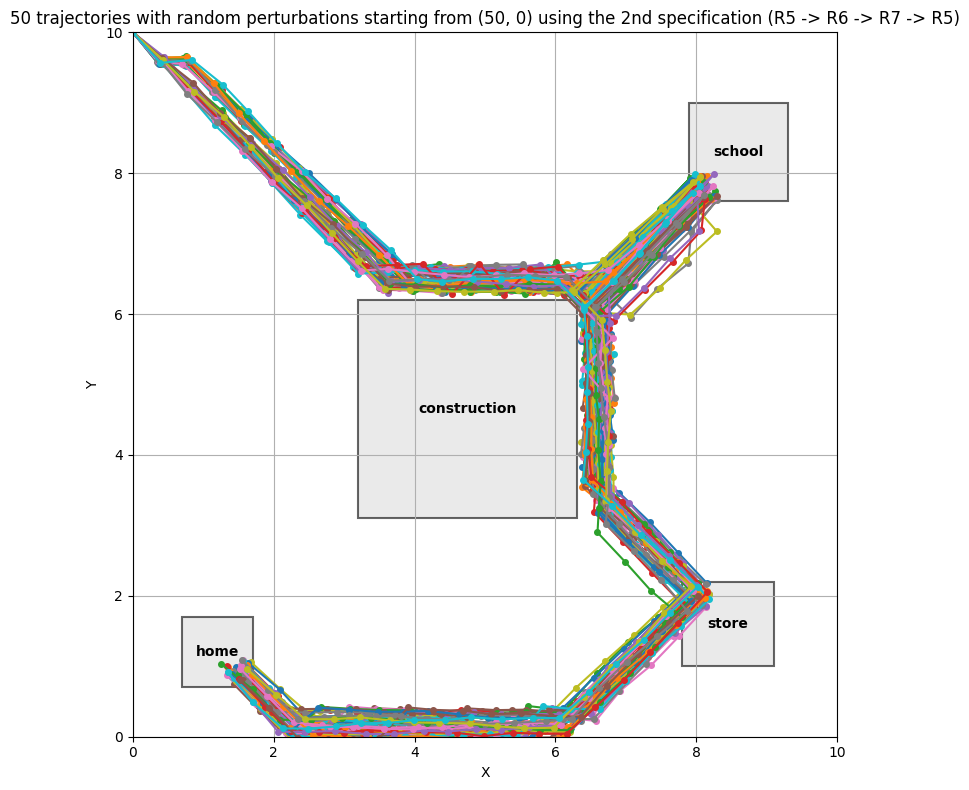

In [ ]:
x1_point = float(input("Enter your starting x1 point in [" + str(x1_min) + ", " + str(x1_max) + "]:"))
x2_point = float(input("Enter your starting x2 point in [" + str(x2_min) + ", " + str(x2_max) + "]:"))
starting_point = [x1_point, x2_point]
start = q(starting_point)

while (start, automaton_initial) not in winning:
    print("Invalid starting point. Try again.")
    x1_point = float(input("Enter your starting x1 point in [" + str(x1_min) + ", " + str(x1_max) + "]:"))
    x2_point = float(input("Enter your starting x2 point in [" + str(x2_min) + ", " + str(x2_max) + "]:"))
    starting_point = [x1_point, x2_point]
    start = q(starting_point)

iterations = int(input("Enter number of iterations you want: "))

if not iterations or iterations <= 0: iterations = 50

paths = []

for i in range(iterations):
    path = find_path_simulation(starting_point,
                  automaton_initial,
                  winning,
                  automaton_transition,
                  automaton_accepting,
                  zones)
    paths.append(path)


plot_regions_and_continuous_paths(
         paths,
         zones,
         zones,
         "50 trajectories with random perturbations starting from (50, 0) using the 2nd specification (R5 -> R6 -> R7 -> R5)"
    )